In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.9.7.29-1+cuda12.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Need to get 885 MB of archives.
After this operation, 56.3 kB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8-dev 8.9.7.29-1+cuda12.2 [440 MB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libcudnn8 8.9.7.29-1+cuda12.2 [444 MB]
Fetched 885 MB in 27s (32.6 MB/s)
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libcudnn8-dev_8.9.7.29-1+cuda12.2_amd64.deb ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
Unpacking libcudnn8-dev (8

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [ ]:
import tensorflow_datasets as tfds

# Load the Oxford-IIIT Pet dataset
dataset_name = 'oxford_iiit_pet'
train_data = tfds.load(dataset_name, split='train[:80%]', as_supervised=False)
validation_data = tfds.load(dataset_name, split='train[80%:90%]', as_supervised=False)
test_data = tfds.load(dataset_name, split='train[90%:100%]', as_supervised=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTH7W4X/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTH7W4X/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
dataset,info = tfds.load('oxford_iiit_pet', with_info = True, as_supervised=True)
print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

In [ ]:
def preprocess(features):
    # Extract image and species label
    # Adjust if the key is different

    image = features['image']
    species = features['species']
    # Continue with your image preprocessing (resize, normalize, etc.)
    # ...
    species = tf.one_hot(species, depth=2)

    return image, species

# Apply the preprocessing function to your dataset
train_data = train_data.map(preprocess)
validation_data = validation_data.map(preprocess)
test_data = test_data.map(preprocess)


In [ ]:
def augment_images(image, species):

  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, species

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)
augmented_validation_data = validation_data.map(augment_images)
validation_batches = augmented_validation_data.batch(32)

In [ ]:
for images, labels in train_batches.take(1):  # Adjust the number inside take() for more batches
    # Print the labels in this batch
    print("Labels in the batch:", labels.numpy())

Labels in the batch: [0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1 0]


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Input

# Define a new input layer that matches the shape you want
new_input = Input(shape=(300, 300, 3))  # Adjust the shape as needed

# Load VGG16 pre-trained model without the top layer (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3),input_tensor=new_input)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(2, activation='softmax')
])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_batches, epochs=10, validation_data=validation_batches)  # Reduced epochs due to pre-trained nature

Epoch 1/10
92/92 [==============================] - 47s 334ms/step - loss: 0.5875 - accuracy: 0.6600 - val_loss: 0.5281 - val_accuracy: 0.7065
Epoch 2/10
92/92 [==============================] - 33s 326ms/step - loss: 0.4896 - accuracy: 0.7524 - val_loss: 0.4556 - val_accuracy: 0.7609
Epoch 3/10
92/92 [==============================] - 31s 293ms/step - loss: 0.4273 - accuracy: 0.8247 - val_loss: 0.4069 - val_accuracy: 0.8587
Epoch 4/10
92/92 [==============================] - 30s 285ms/step - loss: 0.3840 - accuracy: 0.8611 - val_loss: 0.3749 - val_accuracy: 0.9076
Epoch 5/10
92/92 [==============================] - 33s 314ms/step - loss: 0.3506 - accuracy: 0.8859 - val_loss: 0.3452 - val_accuracy: 0.8533
Epoch 6/10
92/92 [==============================] - 32s 306ms/step - loss: 0.3285 - accuracy: 0.8899 - val_loss: 0.3214 - val_accuracy: 0.9076
Epoch 7/10
92/92 [==============================] - 31s 291ms/step - loss: 0.3086 - accuracy: 0.8950 - val_loss: 0.3041 - val_accuracy: 0.9103

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 14715714 (56.14 MB)
Trainable params: 1026 (4.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
print(model.output)
print(model.layers[0])
print(model.layers[-3].output)
print(model.layers[-1].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(2, activation='softmax')(x)

# Create the new CAM model
cam_model = Model(inputs=new_input, outputs=[base_model.get_layer('block5_conv3').output, output])
current_weights, current_biases = cam_model.layers[-1].get_weights()

# Assign gap_weights to the weights part, keeping biases the same
cam_model.layers[-1].set_weights([gap_weights, current_biases])
# Redefine the CAM model using the correct layer outputs
"""cam_model = Model(inputs=base_model.get_layer('block1_conv1').input,
                  outputs=(base_model.get_layers[-3].output,model.layers[-1].output))
"""
# Print summary to check the setup
cam_model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0  

In [ ]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction =  np.argmax(results[0])


  class_labels = ['Cat', 'Dog']
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,np.argmax(results[0])]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/18, 300/18, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)


  predicted_class = class_labels[prediction]

  # visualize the results
  print(f'softmax output: {results}')
  print(f"prediction class: {predicted_class}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  plt.imshow(tf.squeeze(image_value), alpha=0.5)
  plt.show()


In [ ]:
!wget -O cat1.jpg https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
!wget -O cat2.jpg https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
!wget -O catanddog.jpg https://www.telegraph.co.uk/content/dam/news/2023/06/10/TELEMMGLPICT000296384999_16864028803870_trans_NvBQzQNjv4BqrCS9JVgwgb8GODK1xmD4xlHwtdpQwyNje2OyIL7x97s.jpeg
!wget -O dog1.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
!wget -O dog2.jpg https://www.hindustantimes.com/ht-img/img/2023/08/25/1600x900/international_dog_day_1692974397743_1692974414085.jpg

--2023-12-28 12:53:58--  https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg
Resolving www.alleycat.org (www.alleycat.org)... 141.193.213.21, 141.193.213.20
Connecting to www.alleycat.org (www.alleycat.org)|141.193.213.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107329 (105K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 104.81K  --.-KB/s    in 0.008s  

2023-12-28 12:53:58 (12.5 MB/s) - ‘cat1.jpg’ saved [107329/107329]

--2023-12-28 12:53:58--  https://i.natgeofe.com/n/9135ca87-0115-4a22-8caf-d1bdef97a814/75552.jpg
Resolving i.natgeofe.com (i.natgeofe.com)... 23.48.32.75, 23.48.32.66, 2600:1406:3400::173f:f24a, ...
Connecting to i.natgeofe.com (i.natgeofe.com)|23.48.32.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1060932 (1.0M) [image/jpeg]
Saving to: ‘cat2.jpg’

cat2.jpg            100%[===================>]   1.01M  --.-KB/s    in 0.04s   

2023-12-28 12:53:59 (22.5 MB/

1/1 [==============================] - 0s 42ms/step
softmax output: [[0.98936474 0.0106352 ]]
prediction class: Cat


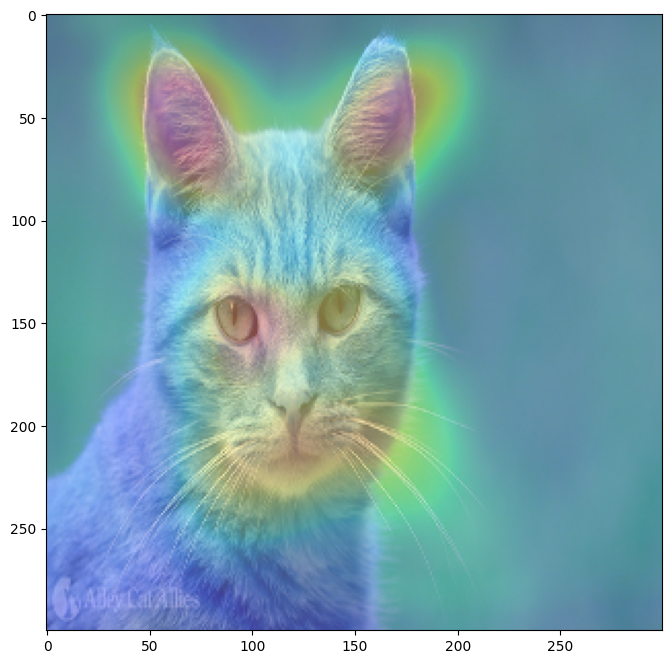

1/1 [==============================] - 0s 18ms/step
softmax output: [[0.95681    0.04318997]]
prediction class: Cat


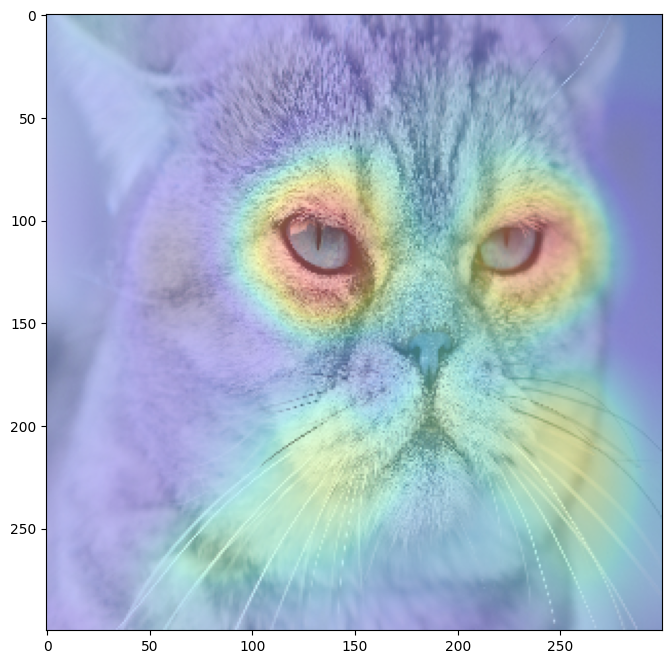

1/1 [==============================] - 0s 28ms/step
softmax output: [[0.05050188 0.9494981 ]]
prediction class: Dog


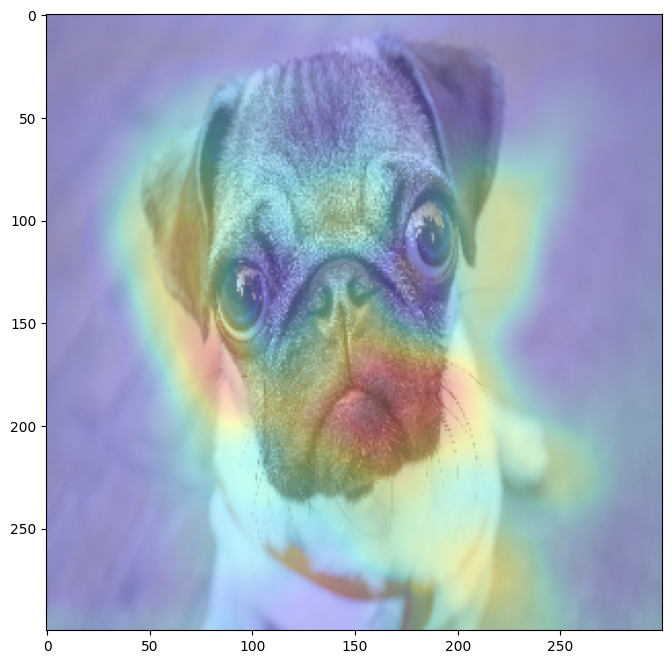

1/1 [==============================] - 0s 26ms/step
softmax output: [[0.06782037 0.93217963]]
prediction class: Dog


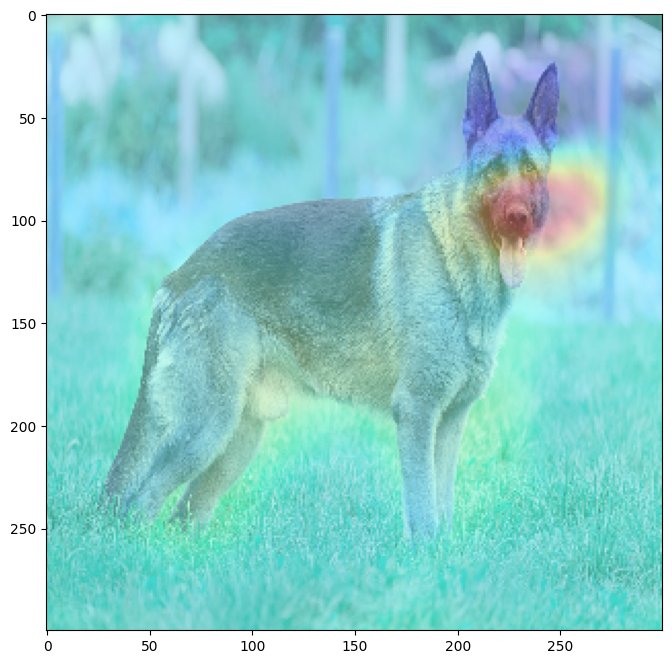

1/1 [==============================] - 0s 30ms/step
softmax output: [[0.01227873 0.98772126]]
prediction class: Dog


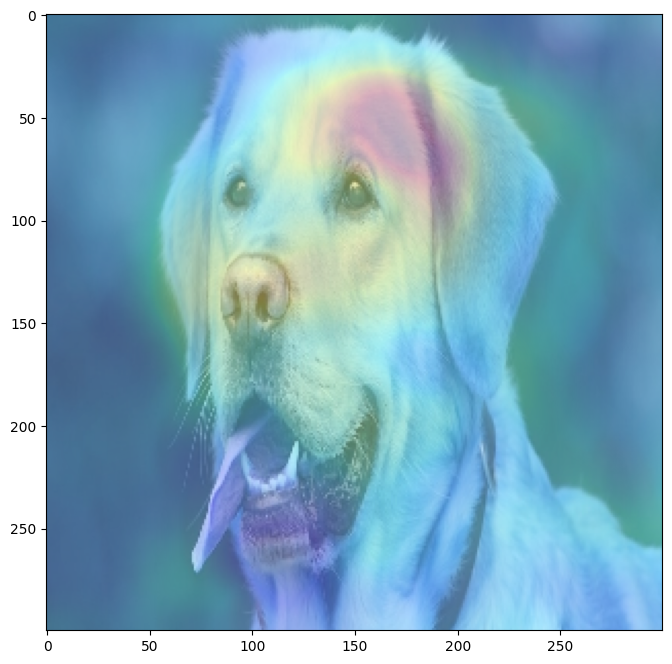

In [ ]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)

  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 [==============================] - 0s 98ms/step
softmax output: [[0.42359212 0.5764079 ]]
prediction class: Dog


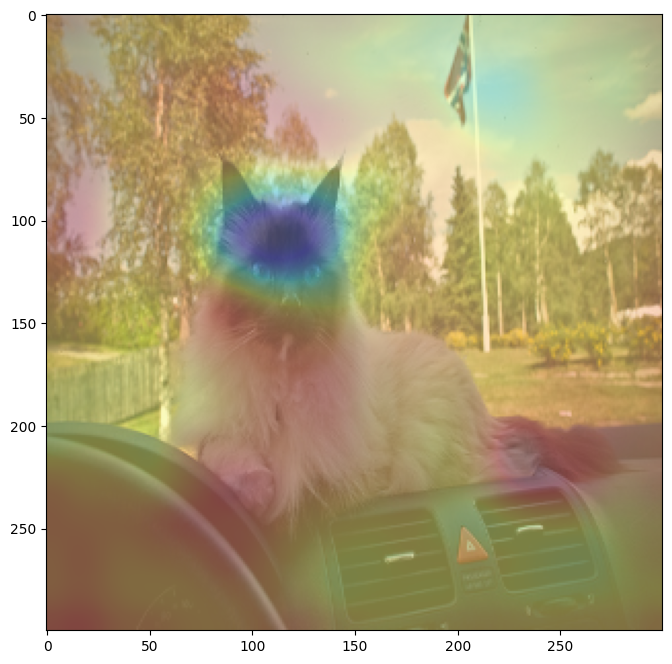

ground truth: dog
1/1 [==============================] - 0s 32ms/step
softmax output: [[0.01896715 0.98103285]]
prediction class: Dog


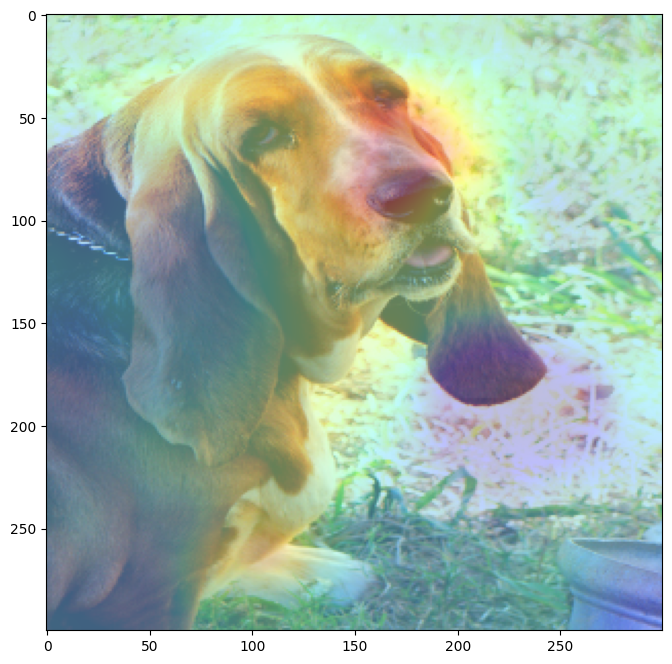

ground truth: dog
1/1 [==============================] - 0s 31ms/step
softmax output: [[0.25061548 0.7493845 ]]
prediction class: Dog


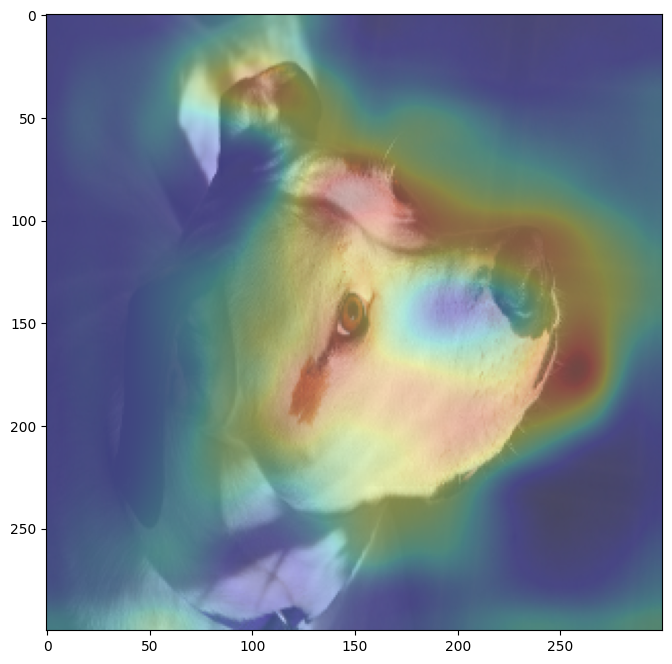

ground truth: dog
1/1 [==============================] - 0s 26ms/step
softmax output: [[0.04543123 0.95456874]]
prediction class: Dog


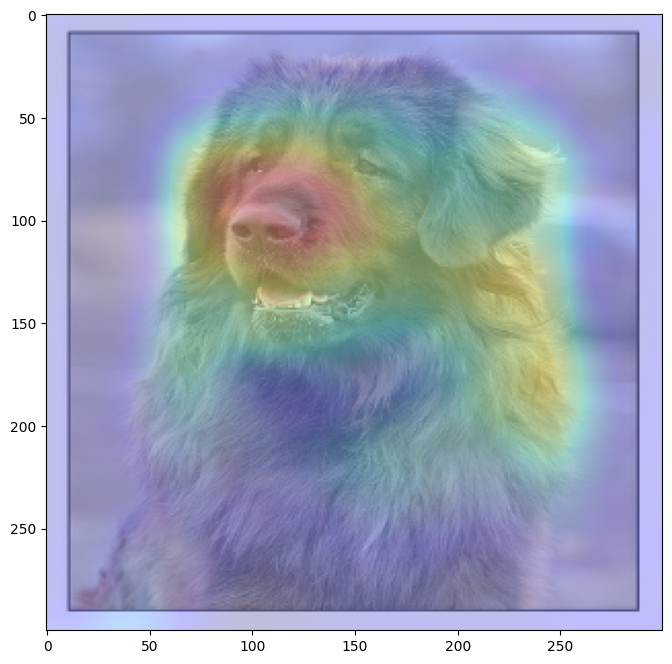

ground truth: cat
1/1 [==============================] - 0s 26ms/step
softmax output: [[0.6981411 0.3018589]]
prediction class: Cat


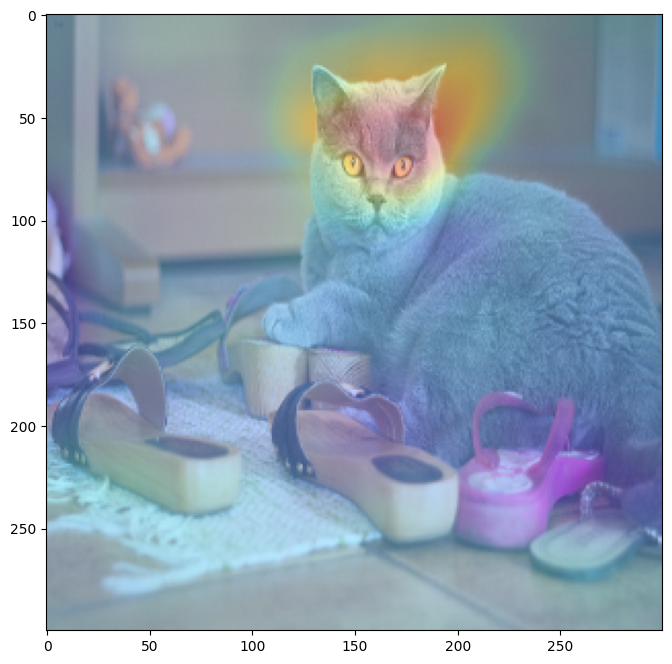

'for img, lbl in test_batches.take(5):\n  print(f"ground truth: {\'dog\' if lbl else \'cat\'}")\n  features,results = cam_model.predict(img)\n  show_cam(img, features, results)'

In [ ]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)

for img, lbl in test_batches.take(5):
    # Convert lbl tensor to numpy and use the first element for condition
    lbl_np = lbl.numpy()
    ground_truth = 'cat' if lbl_np[0][0] == 1 else 'dog'  # Adjust depending on how your labels are encoded

    print(f"ground truth: {ground_truth}")
    features, results = cam_model.predict(img)
    show_cam(img, features, results)

"""for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)"""